# Game Classification Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math

os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models")
game_data = pd.read_csv('game_data.csv') # already filtered buy num_reviews >= 30
# game_data.head() # See the first 5 rows

### clean and filter data

In [2]:
# bgg_games = game_data[game_data['type'] == 'boardgame'] # no expansions
bgg_games = game_data[game_data['year'] > 1980]
# bgg_games = bgg_games[bgg_games['year'] > 1980]
bgg_games = bgg_games[bgg_games['maxplayers'] <= 30]
bgg_games = bgg_games[bgg_games['minplaytime'] <= 180] # 120 - 90th percentile
bgg_games = bgg_games[bgg_games['maxplaytime'] <= 720]
bgg_games = bgg_games[bgg_games['minage'] <= 21]
bgg_games = bgg_games[bgg_games['playingtime'] >= 10]

In [3]:
# cell for data exploration
# bgg_games.columns

### select cells potentially relevant to rating (before community interaction)

In [4]:
dtc_test = bgg_games[['type', 'minplayers', 'maxplayers', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'avg_rating', 'mechanics',
       'bay_rating', 'total_comments', 'total_weights', 'complexity', 'categories']]

In [5]:
# for player pool size
dtc_test = dtc_test[dtc_test['maxplayers'] >= dtc_test['minplayers']]

#### convert mechanics and categories into lists with values

In [6]:
dtc_test['categories'] = dtc_test['categories'].apply(lambda x: x.strip('][').split(', ') )
dtc_test['mechanics'] = dtc_test['mechanics'].apply(lambda x: x.strip('][').split(', ') )

#### count number of mechanics and categories for each game, make new columns

In [7]:
num_mechs = []
num_cats = []
for index, row in dtc_test.iterrows():
    num_mechs.append(len(row['mechanics']))
    num_cats.append(len(row['categories']))

dtc_test['num_mechs'] = num_mechs
dtc_test['num_cats'] = num_cats
dtc_test['player_diff'] = dtc_test.maxplayers - dtc_test.minplayers

In [8]:
# explore data
dtc_test['playingtime'].describe()

count    20905.000000
mean        64.891701
std         54.955134
min         10.000000
25%         30.000000
50%         45.000000
75%         90.000000
max        720.000000
Name: playingtime, dtype: float64

In [9]:
# data exploration
dtc_test['playingtime'].value_counts(dropna=False)

30     3722
60     3703
45     2489
120    2237
90     2227
       ... 
23        1
38        1
165       1
68        1
95        1
Name: playingtime, Length: 65, dtype: int64

In [10]:
# data exploration
dtc_test.loc[dtc_test.playingtime < 10, 'playingtime'].count()

# dtc_test['time_diff'] = dtc_test.maxplaytime - dtc_test.minplaytime

0

In [11]:
def split_data_frame_list(df, target_column, output_type=str):
    ''' 
    Accepts a column with list values and splits into several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = output_type(s)
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = output_type(split_row)
          row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

def dupe_data_frame_list(df, target_column, output_type=list):
    ''' 
    duplicate rows for each value in a list instead (for 'y_test' only)
    '''
    row_accumulator = []

    def dupe_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = output_type(split_row)
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = output_type(split_row)
          row_accumulator.append(new_row)
  
    df.apply(dupe_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

#### split lists into multiple rows for regression model

In [12]:
dtc_test = split_data_frame_list(dtc_test, 'categories')
dtc_test = split_data_frame_list(dtc_test, 'mechanics')

In [13]:
print(list(dtc_test.columns))

['type', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'avg_rating', 'mechanics', 'bay_rating', 'total_comments', 'total_weights', 'complexity', 'categories', 'num_mechs', 'num_cats', 'player_diff']


#### get all desired cols and apply one-hot fix to categorical features

In [14]:
# for filtering cols
desired_cols = ['type', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'avg_rating', 'bay_rating', 'complexity', 'categories', 'mechanics', 'num_mechs', 'num_cats', 'player_diff']

# make dummies (one-hot fix) for categorical values and attach to frame for tree model
model_frame = dtc_test[desired_cols]
mech_dummies = pd.get_dummies(model_frame['mechanics'], prefix='mech', drop_first=True)
model_frame = pd.concat([model_frame, mech_dummies], axis=1)
cat_dummies = pd.get_dummies(model_frame['categories'], prefix='cat', drop_first=True)
model_frame = pd.concat([model_frame, cat_dummies], axis=1)
type_dummies = pd.get_dummies(model_frame['type'], prefix='type', drop_first=True)
model_frame = pd.concat([model_frame, type_dummies], axis=1)

#### filter out categorical columns for tree fitting

In [15]:
# list of just desired features, now including one-hot cols and remove categorical cols
features = list(model_frame.columns)

# remove categorical cols
features.remove('mechanics')
features.remove('categories')
features.remove('type')

# remove target cols
features.remove('avg_rating')
features.remove('bay_rating')

# for col in desired_cols:
#     features.remove(col)
# print(features)

### Divide the data set
#### split data into training portions

In [16]:
# filtered features with one-hot fixes for categorical columns
X = model_frame[features]

# target variable - bays because it's not as dramatic
y = model_frame[['bay_rating']]

# Split method, 0.3 == 30% of data saved for testing, choosen randomly from set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('done!')

done!


### feature selection

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# selection with f_regression for scoring feature relationships
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	# return feature selection model and scores
	return X_train_fs, X_test_fs, fs

Feature 0: 301.770624
Feature 1: 32.370104
Feature 2: 4955.206265
Feature 3: 3285.979632
Feature 4: 4955.206265
Feature 5: 4382.278248
Feature 6: 17519.947168
Feature 7: 22147.586545
Feature 8: 1128.924581
Feature 9: 0.639315
Feature 10: 25.004708
Feature 11: 65.942429
Feature 12: 233.590523
Feature 13: 9.827661
Feature 14: 0.040232
Feature 15: 196.888333
Feature 16: 0.367080
Feature 17: 23.311975
Feature 18: 198.957298
Feature 19: 62.558664
Feature 20: 87.929914
Feature 21: 9.438684
Feature 22: 0.535952
Feature 23: 1.050052
Feature 24: 0.120024
Feature 25: 8.640421
Feature 26: 49.623409
Feature 27: 7.851722
Feature 28: 0.038924
Feature 29: 36.612944
Feature 30: 35.616351
Feature 31: 55.837020
Feature 32: 194.070796
Feature 33: 51.987525
Feature 34: 18.997872
Feature 35: 8.345363
Feature 36: 16.240711
Feature 37: 0.432879
Feature 38: 4.096313
Feature 39: 121.511348
Feature 40: 78.093150
Feature 41: 11.531135
Feature 42: 50.623908
Feature 43: 19.316361
Feature 44: 17.732748
Feature 45: 

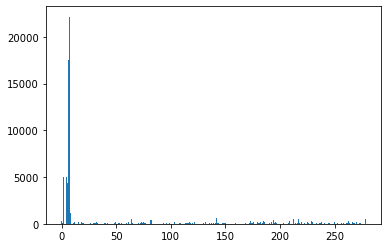

In [18]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Train the model 

In [ ]:
X_train.describe()

In [19]:
from copy import deepcopy

best_r2 = 0
best_mse = math.inf

for j in range(1, 3):
    # Linear Regression Model object
    lgm = LinearRegression()

    # Train Decision Tree Classifer
    lgm = lgm.fit(X_train,y_train)

    # predictions by model for y
    y_pred = lgm.predict(X_test)

    # accuracy check
    mse = mean_squared_error(y_test, y_pred)
    print('Mean squared error: ', mse)
# The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: ', r2)

    if r2 >= best_r2 and mse <= best_mse:
        best_lgm = deepcopy(lgm)
        best_r2 = accuracy
        best_mse = mse
        print("depth: ", j)
        print("best acc: ", accuracy)

print('done!')

LinAlgError: SVD did not converge in Linear Least Squares

# SAVE MODEL!! (and test accuracy of accuracy rating)

In [ ]:
from joblib import dump, load

# swtich to model directory
os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models\models")

# create and save file
joblib_file = "dtc_all_9041.joblib"  
dump(best_dtc, joblib_file)

# test load
joblib_model = load(joblib_file)

y_pred = joblib_model.predict(X_test)

# custom accuracy check
correct = 0
y_targets = y_test["categories"].tolist() 
for i in range(len(y_pred)):
    if y_pred[i] in y_targets[i]:
        correct += 1

print("Accuracy:", correct / len(y_pred))

### visualize training depths

In [ ]:


max_depth = []
acc_gini = []
acc_entropy = []

best_acc = correct / len(y_pred)
best_dtc = dtc

y_targets = y_test["categories"].tolist() 
for i in range(1,36):
    # testing entropy
    dtree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    correct = 0
    for j in range(len(y_pred)):
        if y_pred[j] in y_targets[j]:
            correct += 1

    accuracy = correct / len(y_pred)
    acc_entropy.append(accuracy)
    if accuracy > best_acc:
        best_dtc = deepcopy(dtree)
        best_acc = accuracy
        print("best acc: ", accuracy)

    # testing gini
    dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    correct = 0
    for j in range(len(y_pred)):
        if y_pred[j] in y_targets[j]:
            correct += 1

    accuracy = correct / len(y_pred)
    acc_gini.append(accuracy)

    if accuracy > best_acc:
        best_dtc = deepcopy(dtree)
        best_acc = accuracy
        print("best acc: ", accuracy)

    # track depth for values
    max_depth.append(i)


# data frame with tracked values to graph
df = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
'acc_entropy':pd.Series(acc_entropy),
'max_depth':pd.Series(max_depth)})

In [ ]:
joblib_file = "dtc_8936.joblib"  
dump(best_dtc, joblib_file)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# graph folder
os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models\graphs")

#size 
sns.set(rc={'figure.figsize': (6, 6)})

print(max_depth)
# visualizing changes in parameters
sns.lineplot(x='max_depth', y='acc_gini', data=df)
sns.lineplot(x='max_depth', y='acc_entropy', data=df)
plt.xlabel('max depth')
plt.ylabel('accuracy')
# plt.xlim(1,30)
plt.savefig('gini vs entropy', bbox_inches = 'tight')
plt.show()

### Visualize training tree model

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# dot_data = StringIO()
# # number of unique values in target col
# class_names = list(model_frame.categories.unique())

# # use trained decision tree model, feature columns, and clases in target col
# export_graphviz(dtc, out_file = dot_data, filled=True, rounded=True, special_characters=True,
#                 feature_names = features,
#                 class_names = class_names)

# # creates image and then displays in Jupyter
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('game_classes.png')
# Image(graph.create_png())